<a href="https://colab.research.google.com/github/AlfonsoRafel/Posgrado-IA---UBA/blob/master/08.%20Machine%20Learning%20II/Proyecto_Final_ML_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning I 


## Drive y librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install funpymodeling

In [ ]:
import pandas as pd
from funpymodeling.exploratory import status
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import Counter
import pickle
from keras.models import model_from_json

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, cross_validate, KFold
from sklearn.model_selection import learning_curve
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVR, SVC

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasRegressor
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Función para plotear las curvas de aprendizaje del test de entranamiento y validación.
# Inputs:
# - model: modelo 
# - X: dataset de entrada
# - y: salida
# - scoring: métrica para ela evolución
# - n_instances: cantidad de valores de tamaño del dataset sobre los que se hará el entrenamiento
# - cv: cantidad de folds para el cross-validation
def plot_learning_curve(model, X, y, n_instances = 5, cv=5):
  train_sizes=[*range(int(X.shape[0]/n_instances), int(X.shape[0]*0.8), int(X.shape[0]/n_instances))]
  
  # r2 learning_curves
  train_sizes, train_scores_r2, valid_scores_r2 = learning_curve(model, X, y, train_sizes=train_sizes, cv = cv, scoring = 'r2')
  train_scores_r2_mean = train_scores_r2.mean(axis = 1)
  valid_scores_r2_mean = valid_scores_r2.mean(axis = 1)

  # neg_mean_squared _error learning_curves
  train_sizes, train_scores_mse, valid_scores_mse = learning_curve(model, X, y, train_sizes=train_sizes, cv = cv, scoring = 'neg_mean_squared_error')
  train_scores_mse_mean = -train_scores_mse.mean(axis = 1)
  valid_scores_mse_mean = -valid_scores_mse.mean(axis = 1)
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
  
  plt.style.use('seaborn')
  ax[0].plot(train_sizes, train_scores_r2_mean, label = 'Training error')
  ax[0].plot(train_sizes, valid_scores_r2_mean, label = 'Validation error')
  ax[0].set_ylabel('Metric: r2', fontsize = 14)
  ax[0].set_xlabel('Training set size', fontsize = 14)
  ax[0].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
  ax[0].legend()

  ax[1].plot(train_sizes, train_scores_mse_mean, label = 'Training error')
  ax[1].plot(train_sizes, valid_scores_mse_mean, label = 'Validation error')
  ax[1].set_ylabel('Metric: mse', fontsize = 14)
  ax[1].set_xlabel('Training set size', fontsize = 14)
  ax[1].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
  ax[1].legend()

  return train_scores_r2, train_scores_mse, valid_scores_r2, valid_scores_mse, train_sizes

def plot_learning_curve_emb(model, X, y, n_instances = 5, cv=5):
  train_sizes=[*range(int(X[0].shape[0]/n_instances), int(X[0].shape[0]*0.8), int(X[0].shape[0]/n_instances))]
  
  # r2 learning_curves
  train_sizes, train_scores_r2, valid_scores_r2 = learning_curve(model, X, y, train_sizes=train_sizes, cv = cv, scoring = 'r2')
  train_scores_r2_mean = train_scores_r2.mean(axis = 1)
  valid_scores_r2_mean = valid_scores_r2.mean(axis = 1)

  # neg_mean_squared _error learning_curves
  train_sizes, train_scores_mse, valid_scores_mse = learning_curve(model, X, y, train_sizes=train_sizes, cv = cv, scoring = 'neg_mean_squared_error')
  train_scores_mse_mean = -train_scores_mse.mean(axis = 1)
  valid_scores_mse_mean = -valid_scores_mse.mean(axis = 1)
  
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
  
  plt.style.use('seaborn')
  ax[0].plot(train_sizes, train_scores_r2_mean, label = 'Training error')
  ax[0].plot(train_sizes, valid_scores_r2_mean, label = 'Validation error')
  ax[0].set_ylabel('Metric: r2', fontsize = 14)
  ax[0].set_xlabel('Training set size', fontsize = 14)
  ax[0].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
  ax[0].legend()

  ax[1].plot(train_sizes, train_scores_mse_mean, label = 'Training error')
  ax[1].plot(train_sizes, valid_scores_mse_mean, label = 'Validation error')
  ax[1].set_ylabel('Metric: mse', fontsize = 14)
  ax[1].set_xlabel('Training set size', fontsize = 14)
  ax[1].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
  ax[1].legend()

In [ ]:
tf.test.gpu_device_name()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Descripción del dataset

### Contexto
* El estudio de los mejores productos requiere más que sólo listados de productos. También necesitas saber qué se vende bien y qué no.

### Contenido
* Este conjunto de datos contiene listados de productos, así como clasificaciones de productos y rendimiento de ventas, que no se encuentran en otros conjuntos de datos. Con esto, se puede buscar correlaciones y patrones con respecto al éxito de un producto y los diversos componentes.

### Metodología de recolección
* Los datos provienen de la plataforma de Wish. Básicamente, los productos listados en el conjunto de datos son los que aparecerían si se escribe "summer" en el campo de búsqueda de la plataforma.

### Columnas y Features
* Los datos fueron raspados en la localización francesa (de ahí algunos caracteres latinos no asiáticos como "é" y "à") en la columna del título. El title_orig, por otra parte, contiene el título original (el título base) que se muestra por defecto. Cuando el vendedor proporciona una traducción, ésta aparece en la columna del título. Cuando las columnas title y title_orig son iguales, generalmente significa que el vendedor no especificó una traducción que se mostraría a los usuarios con la configuración francesa.
Una imagen vale más que mil palabras. En la siguiente captura de pantalla se ven algunas características y cómo interpretarlas.

![picture](https://drive.google.com/uc?export=view&id=1_9oIQNz_HzY1UtkD0BYiVve45ueVPkeV)

### Definición del problema
Es posible definir diferentes tipos de problemas al presentarse un dataset tan interesante como el descripto arriba. En este caso particular, se plantea como objetivo predecir el probable ingreso concebido como el producto entre las unidades vendidas (units_sold) y el precio de venta (price). Se tomarán dos enfoques:
* Enfoque 1: se considerará a la variable de salida, nombrada como 'income', con una variable continua, quedando definido un problema de regresión.
* Enfoque 2: se agrupará a los distintos valores de la variable de salida en grupos, quedando definido un problema de clasificación.

Para ambos enfoques se realizará la ingeniería de features pertinente (muy similar en ambos casos salvo por detalles finales) y se probarán una serie de modelos para luego compararlos y elegir el más adecuado en función de las métricas de validación. Por cuestiones de tiempo es probable que sólo se realice uno sólo de los enfoques, en pos de mayor detalle en el análisis.



### Características del dataset

In [ ]:
# Carga de datos desde el .csv
data = pd.read_csv('/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/Machine Learning II/summer-products-with-rating-and-performance_2020-08.csv')

time: 497 ms (started: 2021-01-04 20:22:00 +00:00)


In [ ]:
# Se imprimen las primeras 5 filas del dataset para ganar insights del contenido de los datos
data.head()

,title,title_orig,price,retail_price,currency_buyer,units_sold,uses_ad_boosts,rating,rating_count,rating_five_count,rating_four_count,rating_three_count,rating_two_count,rating_one_count,badges_count,badge_local_product,badge_product_quality,badge_fast_shipping,tags,product_color,product_variation_size_id,product_variation_inventory,shipping_option_name,shipping_option_price,shipping_is_express,countries_shipped_to,inventory_total,has_urgency_banner,urgency_text,origin_country,merchant_title,merchant_name,merchant_info_subtitle,merchant_rating_count,merchant_rating,merchant_id,merchant_has_profile_picture,merchant_profile_picture,product_url,product_picture,product_id,theme,crawl_month
0,2020 Summer Vintage Flamingo Print Pajamas Se...,2020 Summer Vintage Flamingo Print Pajamas Se...,16.00,14,EUR,100,0,3.76,54,26.0,8.0,10.0,1.0,9.0,0,0,0,0,"Summer,Fashion,womenunderwearsuit,printedpajam...",white,M,50,Livraison standard,4,0,34,50,1.0,Quantité limitée !,CN,zgrdejia,zgrdejia,(568 notes),568,4.128521,595097d6a26f6e070cb878d1,0,NaN,https://www.wish.com/c/5e9ae51d43d6a96e303acdb0,https://contestimg.wish.com/api/webimage/5e9ae...,5e9ae51d43d6a96e303acdb0,summer,2020-08
1,SSHOUSE Summer Casual Sleeveless Soirée Party ...,Women's Casual Summer Sleeveless Sexy Mini Dress,8.00,22,EUR,20000,1,3.45,6135,2269.0,1027.0,1118.0,644.0,1077.0,0,0,0,0,"Mini,womens dresses,Summer,Patchwork,fashion d...",green,XS,50,Livraison standard,2,0,41,50,1.0,Quantité limitée !,CN,SaraHouse,sarahouse,"83 % avis positifs (17,752 notes)",17752,3.899673,56458aa03a698c35c9050988,0,NaN,https://www.wish.com/c/58940d436a0d3d5da4e95a38,https://contestimg.wish.com/api/webimage/58940...,58940d436a0d3d5da4e95a38,summer,2020-08
2,2020 Nouvelle Arrivée Femmes Printemps et Été ...,2020 New Arrival Women Spring and Summer Beach...,8.00,43,EUR,100,0,3.57,14,5.0,4.0,2.0,0.0,3.0,0,0,0,0,"Summer,cardigan,women beachwear,chiffon,Sexy w...",leopardprint,XS,1,Livraison standard,3,0,36,50,1.0,Quantité limitée !,CN,hxt520,hxt520,86 % avis positifs (295 notes),295,3.989831,5d464a1ffdf7bc44ee933c65,0,NaN,https://www.wish.com/c/5ea10e2c617580260d55310a,https://contestimg.wish.com/api/webimage/5ea10...,5ea10e2c617580260d55310a,summer,2020-08
3,Hot Summer Cool T-shirt pour les femmes Mode T...,Hot Summer Cool T Shirt for Women Fashion Tops...,8.00,8,EUR,5000,1,4.03,579,295.0,119.0,87.0,42.0,36.0,0,0,0,0,"Summer,Shorts,Cotton,Cotton T Shirt,Sleeve,pri...",black,M,50,Livraison standard,2,0,41,50,NaN,NaN,CN,allenfan,allenfan,"(23,832 notes)",23832,4.020435,58cfdefdacb37b556efdff7c,0,NaN,https://www.wish.com/c/5cedf17ad1d44c52c59e4aca,https://contestimg.wish.com/api/webimage/5cedf...,5cedf17ad1d44c52c59e4aca,summer,2020-08
4,Femmes Shorts d'été à lacets taille élastique ...,Women Summer Shorts Lace Up Elastic Waistband ...,2.72,3,EUR,100,1,3.10,20,6.0,4.0,2.0,2.0,6.0,0,0,0,0,"Summer,Plus Size,Lace,Casual pants,Bottom,pant...",yellow,S,1,Livraison standard,1,0,35,50,1.0,Quantité limitée !,CN,youngpeopleshop,happyhorses,"85 % avis positifs (14,482 notes)",14482,4.001588,5ab3b592c3911a095ad5dadb,0,NaN,https://www.wish.com/c/5ebf5819ebac372b070b0e70,https://contestimg.wish.com/api/webimage/5ebf5...,5ebf5819ebac372b070b0e70,summer,2020-08


time: 85.3 ms (started: 2021-01-04 20:22:01 +00:00)


In [ ]:
# Análisis de los tipos de datos: se utiliza el método status() de la libreria funpymodeling el cual brinda rápidamente información 
# general del dataset:
# - q_nan: cantidad de nan values
# - p_nan: porcentaje de nan values
# - q_zeros: cantidad de zero values
# - p_zeros: porcentaje de zero values
# - unique: cantidad de elementos únicos por columna
# - type: tipo de datos de la columna
# Gracias a este método se logra un análisis integral bastante rápido, entendiendo cuales features son categóricas o numéricas,
# features con únicos valores, features con ids, cantidad de nan y zero values y su distribución. 
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,title,0,0.000000,0,0.000000,1201,object
1,title_orig,0,0.000000,0,0.000000,1203,object
2,price,0,0.000000,0,0.000000,127,float64
3,retail_price,0,0.000000,0,0.000000,104,int64
4,currency_buyer,0,0.000000,0,0.000000,1,object
5,units_sold,0,0.000000,0,0.000000,15,int64
6,uses_ad_boosts,0,0.000000,892,0.567069,2,int64
7,rating,0,0.000000,0,0.000000,192,float64
8,rating_count,0,0.000000,45,0.028608,761,int64
9,rating_five_count,45,0.028608,31,0.019708,605,float64


time: 65.4 ms (started: 2021-01-04 20:22:01 +00:00)


In [ ]:
# Generación de la variable de salida: se define a la variable de salida como el producto entre las unidades vendidas 
# y el precio de las mismas
data_reg = data.copy()
data_reg['income'] = data_reg['units_sold'] * data_reg['price']

time: 3.76 ms (started: 2021-01-04 20:22:03 +00:00)


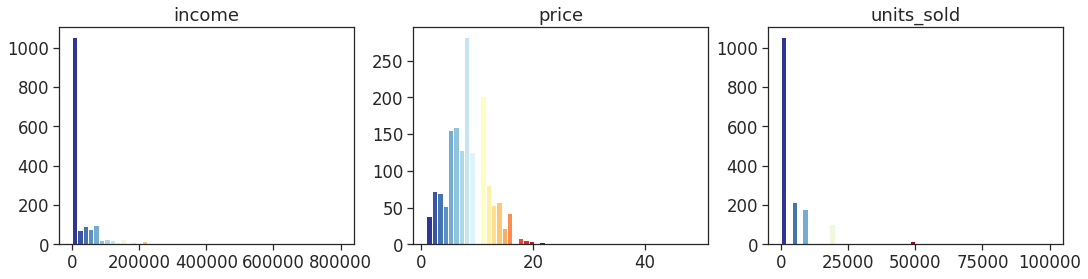

time: 851 ms (started: 2021-01-04 20:22:04 +00:00)


In [ ]:
# Histograma de la variable de salida:
# Mediante el histograma de las variables que conforman a la variable de salida y de ella en si misma, notamos que estamos frente 
# a un dataset muy sesgado, donde los valores más extremos podrían ser considerados como outliers. Podemos observar también que la 
# variable 'units_sold' no presenta uan distribución continua.
fig, ax_var = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
var_list = ['income', 'price', 'units_sold']
i=0
for ax in ax_var:
    n, bins, patches = ax.hist(data_reg[var_list[i]], bins=50)
    ax.set_title(var_list[i])
    cm = plt.cm.RdYlBu_r
    for j, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(j/20))
    i = i+1

In [ ]:
# Correlación de la salida con las distintas variables:
# De la correlación obtenemos una idea de cuales features presentan una correlación de tipo lineal con salida. 
# En este caso particular observamos que tanto las unidades vendidas como los distintos ratings muestran una correlación lineal.
# Podría considerarse eliminar las features que presentan un valor cercano a cero de correlación. Para este caso particular preferimos
# conservarlas con el supuesto de que la relación que presentan es mas bien no lineal y que su eliminación podría conllevar a una pérdida 
# de información.
corr_matrix = data_reg.corr()
corr_matrix['income'].sort_values(ascending=False)

income                          1.000000
units_sold                      0.913674
rating_count                    0.834427
rating_four_count               0.830484
rating_three_count              0.819853
rating_five_count               0.811791
rating_two_count                0.797720
rating_one_count                0.784595
merchant_rating_count           0.243517
product_variation_inventory     0.161312
merchant_has_profile_picture    0.160269
merchant_rating                 0.139952
price                           0.137973
shipping_option_price           0.115283
badge_product_quality           0.081479
retail_price                    0.072850
badges_count                    0.067883
rating                          0.042980
badge_local_product             0.009814
badge_fast_shipping             0.003764
inventory_total                -0.004891
shipping_is_express            -0.010280
uses_ad_boosts                 -0.011291
countries_shipped_to           -0.026730
has_urgency_bann

time: 15.7 ms (started: 2021-01-04 20:22:06 +00:00)


## Análisis como un problema de regresión

#### Ingeniería de Features



In [ ]:
# Precio: 
# Al observarse la baja proporción de casos con precio mayor a 20 (<1%) se procede a eliminar las intancias correspondientes del dataset
print('Precio mayor o igual a 20{}'.format(data_reg[data_reg['price'] >= 20].shape))
print('Precio menor a 20{}'.format(data_reg[data_reg['price'] < 20].shape))

data_reg_lim = data_reg[data_reg['price'] < 20]

Precio mayor o igual a 20(13, 44)
Precio menor a 20(1560, 44)
time: 8.03 ms (started: 2021-01-04 20:22:09 +00:00)


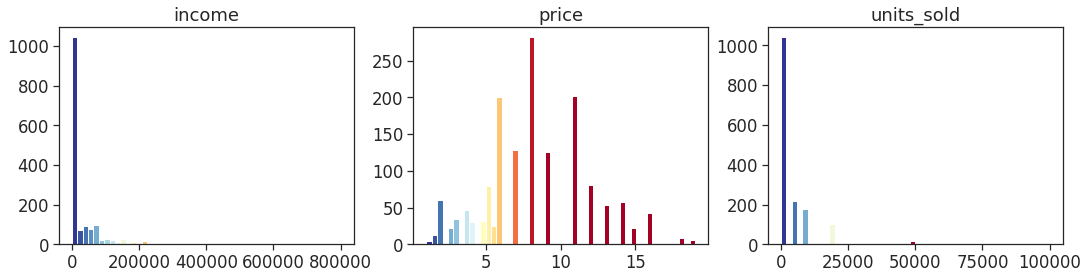

time: 733 ms (started: 2021-01-04 20:22:11 +00:00)


In [ ]:
# Histograma de la variable de salida con precios menores a 20
fig, ax_var = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
var_list = ['income', 'price', 'units_sold']
i=0
for ax in ax_var:
    n, bins, patches = ax.hist(data_reg_lim[var_list[i]], bins=50)
    ax.set_title(var_list[i])
    cm = plt.cm.RdYlBu_r
    for j, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(j/20))
    i = i+1


In [ ]:
# Unidades vendidas: 
# Al observarse la baja proporición de casos con unidades vendidas mayor a 50000 (<2%) se procede a eliminar las intancias correspondientes del dataset
print('Unidades vendidas mayor o igual a 50000{}'.format(data_reg[data_reg['units_sold'] >= 50000].shape))
print('Unidades vendidas menor a 50000{}'.format(data_reg[data_reg['units_sold'] < 50000].shape))

data_reg_lim = data_reg_lim[data_reg_lim['units_sold'] < 50000]

Unidades vendidas mayor o igual a 50000(23, 44)
Unidades vendidas menor a 50000(1550, 44)
time: 13.2 ms (started: 2021-01-04 20:22:14 +00:00)


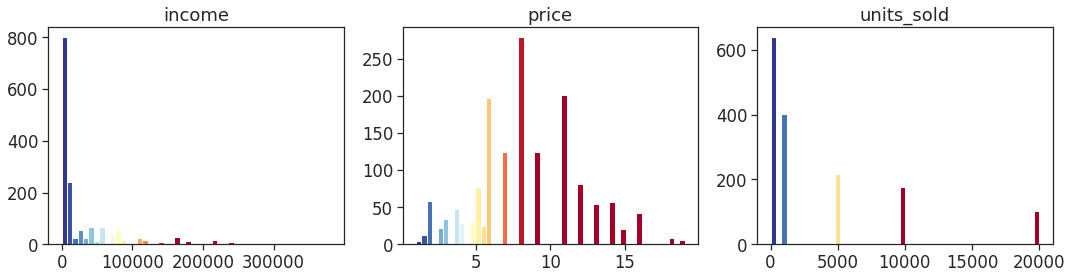

time: 719 ms (started: 2021-01-04 20:22:14 +00:00)


In [ ]:
# Histograma de la variable de salida con precios unidades vendidas menores a 50000
fig, ax_var = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))
var_list = ['income', 'price', 'units_sold']
i=0
for ax in ax_var:
    n, bins, patches = ax.hist(data_reg_lim[var_list[i]], bins=50)
    ax.set_title(var_list[i])
    cm = plt.cm.RdYlBu_r
    for j, p in enumerate(patches):
        plt.setp(p, 'facecolor', cm(j/20))
    i = i+1

In [ ]:
# Eliminamos todas la features con unique = 1, ya que no agregarán información extra
# para la predicción de la salida
data_reg_lim = data_reg_lim.loc[:, data_reg_lim.nunique() > 1]
status(data_reg_lim)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,title,0,0.000000,0,0.000000,1167,object
1,title_orig,0,0.000000,0,0.000000,1168,object
2,price,0,0.000000,0,0.000000,118,float64
3,retail_price,0,0.000000,0,0.000000,103,int64
4,units_sold,0,0.000000,0,0.000000,13,int64
5,uses_ad_boosts,0,0.000000,871,0.566688,2,int64
6,rating,0,0.000000,0,0.000000,191,float64
7,rating_count,0,0.000000,45,0.029278,736,int64
8,rating_five_count,45,0.029278,31,0.020169,580,float64
9,rating_four_count,45,0.029278,96,0.062459,417,float64


time: 64.6 ms (started: 2021-01-04 20:22:16 +00:00)


In [ ]:
# Se binariza el feature 'urgency_text', reemplazando por 0 los nan values y por 1 cualquier otro valor. Se procedió
# de esta manera ya que existe una sola instancia con 'Réduction sur les achats en gros'
data_reg_lim['urgency_text'].fillna(0, inplace=True)
data_reg_lim['urgency_text'].replace('Quantité limitée !', 1, inplace=True)
data_reg_lim['urgency_text'].replace('Réduction sur les achats en gros', 1, inplace=True)

time: 4.92 ms (started: 2021-01-04 20:22:18 +00:00)


In [ ]:
# Se eliminan ciertas columnas por varios motivos:
# - Dificultad para el procesamiento: tanto 'title', 'tags', entre otras, precisan de un tratamiento más delicado
#   el cual considero no está dentro del scope de este trabajo. Se evaluarán los resultados de los algoritmos y se incluirán en caso 
#   de que los mismos no sean exitosos.
# - Información no relavante: 'product_picture', 'product_url', no tendrían información relevante para el análisis tabular llevado a cabo 
#   en este trabajo. Posiblemente podría agregarse una instancia de Computer Vision para el tratamiento de imágenes, lo cual también está
#   fuera del scope.
data_reg_lim.drop(['title','title_orig','merchant_name', 'product_picture','product_url', 'merchant_profile_picture', 'merchant_title', 'merchant_info_subtitle','tags'], axis=1, inplace=True)

time: 8.59 ms (started: 2021-01-04 20:22:19 +00:00)


In [ ]:
# Nan values:
# Se calcula la cantidad de nan values y se la compara contra la cantidad total de datos. Con un valor menor a un 8% se decide eliminar
# todas las instancias que presenten nan, lo cual podría no ser una decisión acertada. Por simplicidad se tomará esta decisión y se 
# confirmará si fue correcta o no al evaluar los resultados de los distintos modelos.
data_nans = data_reg_lim.loc[data_reg_lim.isna().sum(axis=1) >= 1, :]
print('Cantidad de filas con nans {}'.format(data_nans.shape))

data_not_nans = data_reg_lim.loc[data_reg_lim.isna().sum(axis=1) == 0, :]
print('Cantidad de filas sin nans {}'.format(data_not_nans.shape))

Cantidad de filas con nans (107, 31)
Cantidad de filas sin nans (1430, 31)
time: 13.1 ms (started: 2021-01-04 20:22:20 +00:00)


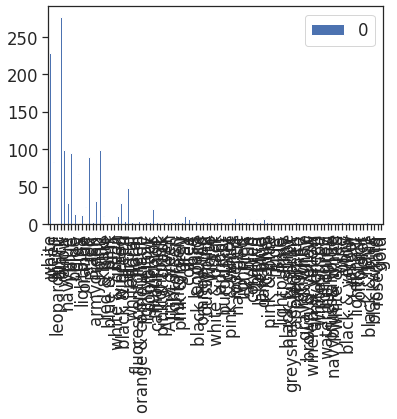

time: 1.2 s (started: 2021-01-04 20:22:22 +00:00)


In [ ]:
# Histograma de 'product color':
# A modo complementario se realizo un histograma de la feature 'product_color'. El gráfico no está del todo
# prolijo, pero del mismo se puede observar la distribución poco ecualizada de sus valores. 
letter_counts = Counter(data_not_nans['product_color'])
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

In [ ]:
# Ids:
# Se selecciona las features correspondientes a Ids para su futura utilización como embeddings. Tanto 'product_color' 
# como 'product_variation_size_id'se considerarán como Ids debido a la gran cantidad de valores unicos que presentan,
# lo cual hace inviable su procesamiento mediante el método hot encoding.
data_reg_no_id = data_not_nans.drop(['product_color', 'product_variation_size_id','merchant_id', 'product_id'], axis=1, inplace=False)

# Se crean los index de los ids para su uso como embeddings
id = []
id_names = ['product_color', 'product_variation_size_id','merchant_id', 'product_id']
idx = []
id2idx = []
i=0

for name in id_names:
  id.append(data_not_nans[name].to_numpy())
  _, _idx = np.unique(id[i], return_inverse=True)
  idx.append(_idx)
  id2idx.append({id:idx for id,idx in zip(id[i], idx[i])})
  i=+1


time: 16.2 ms (started: 2021-01-04 20:22:25 +00:00)


In [ ]:
# One hot encoding:
# Una vez generados los idx para los id, se procede a preprocesar las variables categóricas restantes.
# Se utiliza el método one hot encoding ya que poseen relativamente pocos valores únicos (a diferencia de los ids). 
data_categorical = data_reg_no_id[['shipping_option_name', 'origin_country']]
dummies = pd.get_dummies(data=data_categorical, columns=data_categorical.columns)
data_not_categorical = data_reg_no_id.drop(['shipping_option_name', 'origin_country'], axis=1, inplace=False)
data_reg_full = pd.concat([data_not_categorical, dummies], axis=1)
print('Tamaño del dataset de numérico: {}'.format(data_not_categorical.shape))
print('Tamaño del dataset de dummies: {}'.format(dummies.shape))
print('Tamaño del dataset con one hot encoding: {}'.format(data_reg_full.shape))

Tamaño del dataset de numérico: (1430, 25)
Tamaño del dataset de dummies: (1430, 19)
Tamaño del dataset con one hot encoding: (1430, 44)
time: 139 ms (started: 2021-01-04 20:22:27 +00:00)


In [ ]:
# Correlación de la salida con las distintas features:
# Se vuelve a calcular la correlación una vez aplicado el one hot encoding.
# Se observan bajas correlaciones lineales para las nuevas features, lo que podría ser una oportunidad para realizar
# más ingeniería. 
corr_matrix = data_reg_full.corr()
corr_matrix['income'].sort_values(ascending=False)

income                                          1.000000
units_sold                                      0.910294
rating_count                                    0.796692
rating_five_count                               0.788518
rating_four_count                               0.779679
rating_three_count                              0.765727
rating_two_count                                0.750881
rating_one_count                                0.741402
price                                           0.242286
shipping_option_price                           0.213624
product_variation_inventory                     0.208787
merchant_rating                                 0.178914
merchant_rating_count                           0.160493
merchant_has_profile_picture                    0.125116
rating                                          0.118913
badge_product_quality                           0.110790
badges_count                                    0.088308
retail_price                   

time: 17 ms (started: 2021-01-04 20:22:30 +00:00)


In [ ]:
# Divivir el dataset en train, test:
# Mediante el random_state, se permutan aleatoriamente los intancias del dataset. De todas maneras esto no garantiza distribuciones 
# similares en train y test set y que la información en ambos sea representativa. Esto se puede solucionar mediante el uso de
# stratified sampling, el cual consiste en dividir el dataset en stratas o grupos basados en un feature y garantizar una distribución homogénea
# en el train y el test set. Como nuestra variable de salida es 'continua', generamos rangos implementando la variable 'price_cat' y aplicamos
# el 'stratify' sobre ella. Otra opción es usar cross_validation para el entrenamiento, el cual se llevará a cabo generando una mejor 
# distribución de los datos entre train y test.
# Otro paso importante es eliminar las features 'price' y 'units_sold' del dataset una vez que se generó la salida, evitando así 
# que existe información correlacionada directamente con la salida. Este proceso fue realizado posterior a un primer entrenamiento, 
# notando claramente como las métricas de validación empeoraban al quitar estas features. 
criteria = [data_reg_full['price'].between(0, 5), data_reg_full['price'].between(5, 10), 
            data_reg_full['price'].between(10, 15), data_reg_full['price'].between(15, 20)]
values = [0, 1, 2, 3]
data_reg_full['price_cat'] = np.select(criteria, values, 0)

dataset_no_id_final = data_reg_full.drop(['income'], axis=1, inplace=False)
X = dataset_no_id_final
y = data_reg_full.income
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify= X.price_cat)
x_train.drop(['price_cat', 'units_sold', 'price'], axis=1, inplace=True)
x_test.drop(['price_cat', 'units_sold', 'price'], axis=1, inplace=True)


time: 27.7 ms (started: 2021-01-04 20:22:31 +00:00)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Divivir el dataset en train, test para embeddings
dataset_no_id_final = data_reg_full.drop(['income'], axis=1, inplace=False)
X_emb = dataset_no_id_final
i = 0
for name in id_names:
  X_emb[name] = idx[i].reshape(-1,1)
  i=+1
y_emb = data_reg_full.income

x_train_emb, x_test_emb, y_train_emb, y_test_emb = train_test_split(X_emb, y_emb, test_size=0.1, random_state=42, stratify= X_emb.price_cat)

idx_train = x_train_emb[['product_color', 'product_variation_size_id','merchant_id', 'product_id']]
x_train_emb.drop(['product_color', 'product_variation_size_id','merchant_id', 'product_id','price_cat', 'units_sold', 'price'], axis=1, inplace=True)

idx_test = x_test_emb[['product_color', 'product_variation_size_id','merchant_id', 'product_id']]
x_test_emb.drop(['product_color', 'product_variation_size_id','merchant_id', 'product_id','price_cat', 'units_sold', 'price'], axis=1, inplace=True)

time: 22.8 ms (started: 2021-01-04 20:22:33 +00:00)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# Normalización de datos:
# Se normalizan los datos para que las diferentes escalas de las features no afecten a la convergibilidad de los optimizadores
sscaler = preprocessing.StandardScaler()
x_train_norm = sscaler.fit_transform(x_train)
x_test_norm = sscaler.fit_transform(x_test)
y_train_norm = sscaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_norm = sscaler.fit_transform(y_test.to_numpy().reshape(-1,1))

time: 13.6 ms (started: 2021-01-04 20:22:36 +00:00)


In [ ]:
# Normalización de datos con embeddings:
# Se normalizan los datos para que las diferentes escalas de las features no afecten a la convergibilidad de los optimizadores
sscaler = preprocessing.StandardScaler()
x_train_emb_norm = sscaler.fit_transform(x_train_emb)
x_test_emb_norm = sscaler.fit_transform(x_test_emb)
y_train_emb_norm = sscaler.fit_transform(y_train_emb.to_numpy().reshape(-1,1))
y_test_emb_norm = sscaler.fit_transform(y_test_emb.to_numpy().reshape(-1,1))

time: 16.8 ms (started: 2021-01-04 20:22:39 +00:00)


#### Modelos

#### Linear Regression

In [ ]:
0# Linear Regression:
# Como primer modelo se elije una regresión lineal. Se observa que el score varia dependiendo del fold con el cual se realice el 
# entrenamiento, de donde podemos concluir que las features tienen relaciones más bien no lineales con la salida.
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, x_train_norm, y_train, cv=5)
print('Scores Linear Regression:  {}'.format(lr_scores))
print('Mean Score Linear Regression:  {}'.format(lr_scores.mean()))

Scores Linear Regression:  [-1.32458101e+26  6.78644932e-01 -1.16889491e+26 -1.80177195e+26
 -1.77653992e+23]
Mean Score Linear Regression:  -8.594048818391763e+25
time: 62.4 ms (started: 2021-01-04 20:22:50 +00:00)


#### Polynomial Regression

In [ ]:
# Polynomial Regression:
# Se calculan modelo de orden 2 y 3 observando una clara mejoría al incluir no linealidades en los modelos.
# Tanto para orden 2 como 3 se observan valores muy grandes de MSE, lo cual indica que no se están fiteando los datos
# correctamente. De todas maneras al aumentar el orden, existe una significativa disminución del error. Se podría
# seguir aumentando el orden de los polinomios, pero sería muy costoso computacionalmente, por lo cual se opta
# por probar modelos más complejos. 
for i in range(2, 4, 1):
  poly = preprocessing.PolynomialFeatures(degree=i)
  x_train_poly = poly.fit_transform(x_train_norm)
  clf = LinearRegression()
  clf_scores = cross_val_score(clf, x_train_poly, y_train, cv=5)
  print('Scores Polynomio orden '+ str(i) +': {}'.format(clf_scores))
  print('Mean Score Polynomio orden '+ str(i) +': {}'.format(clf_scores.mean()))

Scores Polynomio orden 2: [-6.63128341e+22 -4.01960912e+21 -1.38383350e+24 -5.78993228e+20
 -3.84041146e+22]
Mean Score Polynomio orden 2: -2.9862981008151782e+23
Scores Polynomio orden 3: [-3.98524876e+16 -4.94539463e+15 -6.38646456e+15 -2.21338459e+19
 -1.84346012e+15]
Mean Score Polynomio orden 3: -4.4373747357953464e+18
time: 15.6 s (started: 2021-01-04 20:22:53 +00:00)


#### Random Forest

In [ ]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=5)
rf_scores = cross_val_score(rf_model, x_train_norm, y_train_norm.ravel(), cv=5)
print('Scores Random Forest:  {}'.format(rf_scores))
print('Mean Score Random Forest:  {}'.format(rf_scores.mean()))

Scores Random Forest:  [0.83415012 0.75733366 0.8349301  0.80692821 0.7867375 ]
Mean Score Random Forest:  0.8040159178380272
time: 3.54 s (started: 2021-01-05 15:39:37 +00:00)


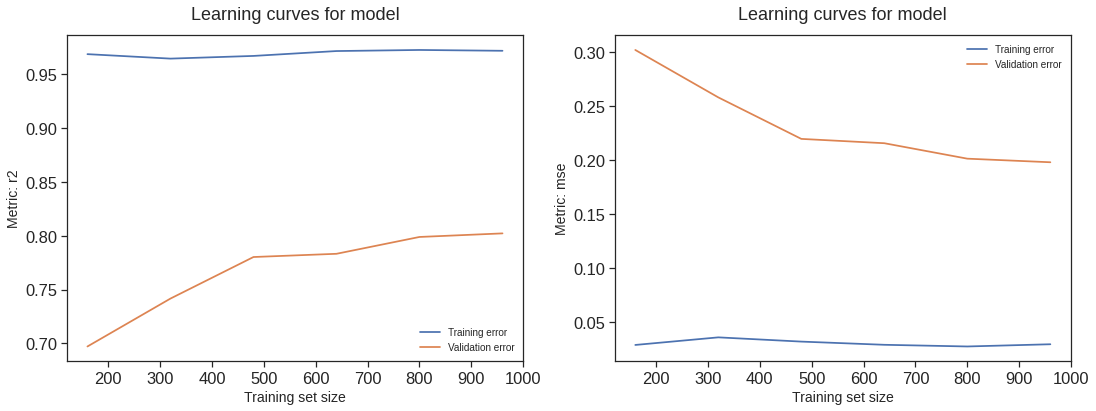

time: 27.3 s (started: 2021-01-04 20:23:33 +00:00)


In [ ]:
rf_train_r2, rf_train_mse, rf_valid_r2, rf_valid_mse, train_sizes = plot_learning_curve(rf_model, x_train_norm, y_train_norm.ravel(), n_instances = 8, cv=5)

#### Support Vector Machines

In [ ]:
# Support Vector Machines
svm_model = SVR(kernel='rbf', C = 2)
svm_scores = cross_val_score(svm_model, x_train_norm, y_train_norm.ravel(), cv=5)
print('Scores SVR:  {}'.format(svm_scores))
print('Mean Score SVR:  {}'.format(svm_scores.mean()))


Scores SVR:  [0.77378105 0.67045914 0.72526458 0.75532157 0.69135712]
Mean Score SVR:  0.7232366913834511
time: 539 ms (started: 2021-01-04 20:25:12 +00:00)


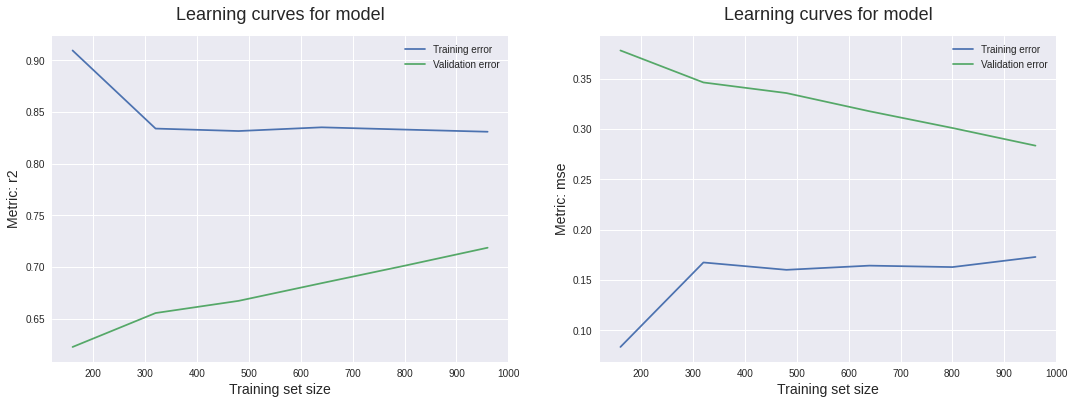

time: 3.97 s (started: 2021-01-04 20:25:14 +00:00)


In [ ]:
svm_train_r2, svm_train_mse, svm_valid_r2, svm_valid_mse, train_sizes = plot_learning_curve(svm_model, x_train_norm, y_train_norm.ravel(), n_instances = 8, cv=5)

#### Deep Learning Model

In [ ]:
# Deep Learning Model
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('linear'))
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='MeanSquaredError', metrics='MeanAbsolutePercentageError')

  return model


time: 7.28 ms (started: 2021-01-04 20:25:18 +00:00)


In [ ]:
model = create_model()
nn_model = create_model()
nn_model.fit(
    x_train_norm.astype(np.float32), 
    y_train_norm.astype(np.float32),
   epochs=100,
    batch_size=64,
    validation_data=(x_test_norm, y_test_norm),
)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
nn_model_sk = KerasRegressor(build_fn = create_model, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=False)
nn_scores = cross_val_score(nn_model_sk, x_train_norm, y_train_norm.ravel(), cv=5)
print('Scores NN:  {}'.format(nn_scores))
print('Mean Score NN:  {}'.format(nn_scores.mean()))

Epoch 1/100
21/21 [==============================] - 1s 15ms/step - loss: 1.0781 - mean_absolute_percentage_error: 139.1670 - val_loss: 0.4835 - val_mean_absolute_percentage_error: 87.1900
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.4115 - mean_absolute_percentage_error: 81.2894 - val_loss: 0.3298 - val_mean_absolute_percentage_error: 66.1937
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 0.2495 - mean_absolute_percentage_error: 69.8160 - val_loss: 0.3052 - val_mean_absolute_percentage_error: 64.0519
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1944 - mean_absolute_percentage_error: 66.8551 - val_loss: 0.3184 - val_mean_absolute_percentage_error: 57.8711
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2033 - mean_absolute_percentage_error: 64.9978 - val_loss: 0.3396 - val_mean_absolute_percentage_error: 59.5750
Epoch 6/100
21/21 [==============================] - 0s 3ms/ste

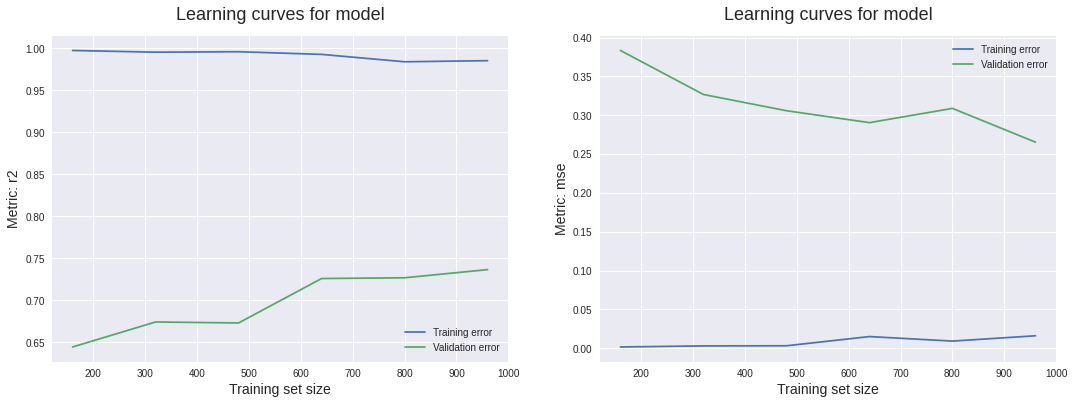

time: 1min 56s (started: 2021-01-04 20:25:55 +00:00)


In [ ]:
nn_train_r2, nn_train_mse, nn_valid_r2, nn_valid_mse, train_sizes =plot_learning_curve(nn_model_sk, x_train_norm, y_train_norm.ravel(), n_instances = 8, cv = 5)

#### Deep Learning Model with Embeddings

In [ ]:
# Deep Learning con embeddings
def create_model_embedding():
    # Create model
    features_input = tf.keras.Input(shape=(x_train_emb.shape[1],), name='features')
    
    # Embeeding
    product_color_idx_input = tf.keras.Input(shape=(1,), name='product_color_idx')   
    product_color_embedding = tf.keras.layers.Embedding(idx[0].max()+1, 8, input_length=1, name='product_color_embedding')(product_color_idx_input)
    product_color_embedding = tf.keras.layers.Flatten()(product_color_embedding)

    product_size_idx_input = tf.keras.Input(shape=(1,), name='product_size_idx')   
    product_size_embedding = tf.keras.layers.Embedding(idx[1].max()+1, 8, input_length=1, name='product_size_embedding')(product_size_idx_input)
    product_size_embedding = tf.keras.layers.Flatten()(product_size_embedding)

    merchant_idx_input = tf.keras.Input(shape=(1,), name='merchant_idx')   
    merchant_embedding = tf.keras.layers.Embedding(idx[2].max()+1, 8, input_length=1, name='merchant_embedding')(merchant_idx_input)
    merchant_embedding = tf.keras.layers.Flatten()(merchant_embedding)

    product_idx_input = tf.keras.Input(shape=(1,), name='product_idx')   
    product_embedding = tf.keras.layers.Embedding(idx[3].max()+1, 8, input_length=1, name='product_embedding')(product_idx_input)
    product_embedding = tf.keras.layers.Flatten()(product_embedding)

  

    concatenated = tf.keras.layers.Concatenate()([features_input, product_color_embedding,  product_size_embedding,  
                                                  merchant_embedding, product_embedding])

    out = tf.keras.layers.Dense(100)(concatenated)
    out = tf.keras.layers.Activation('relu')(out)
    out = tf.keras.layers.Dense(100)(out)
    out = tf.keras.layers.Activation('relu')(out)
    out = tf.keras.layers.Dense(1)(out)
    out = tf.keras.layers.Activation('linear')(out)

    model = tf.keras.Model(
        inputs = [features_input, product_color_idx_input,  product_size_idx_input, merchant_idx_input, product_idx_input],
        outputs = out,
    )
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='MeanSquaredError', metrics='MeanAbsolutePercentageError')

    return model

time: 35.1 ms (started: 2021-01-04 20:28:12 +00:00)


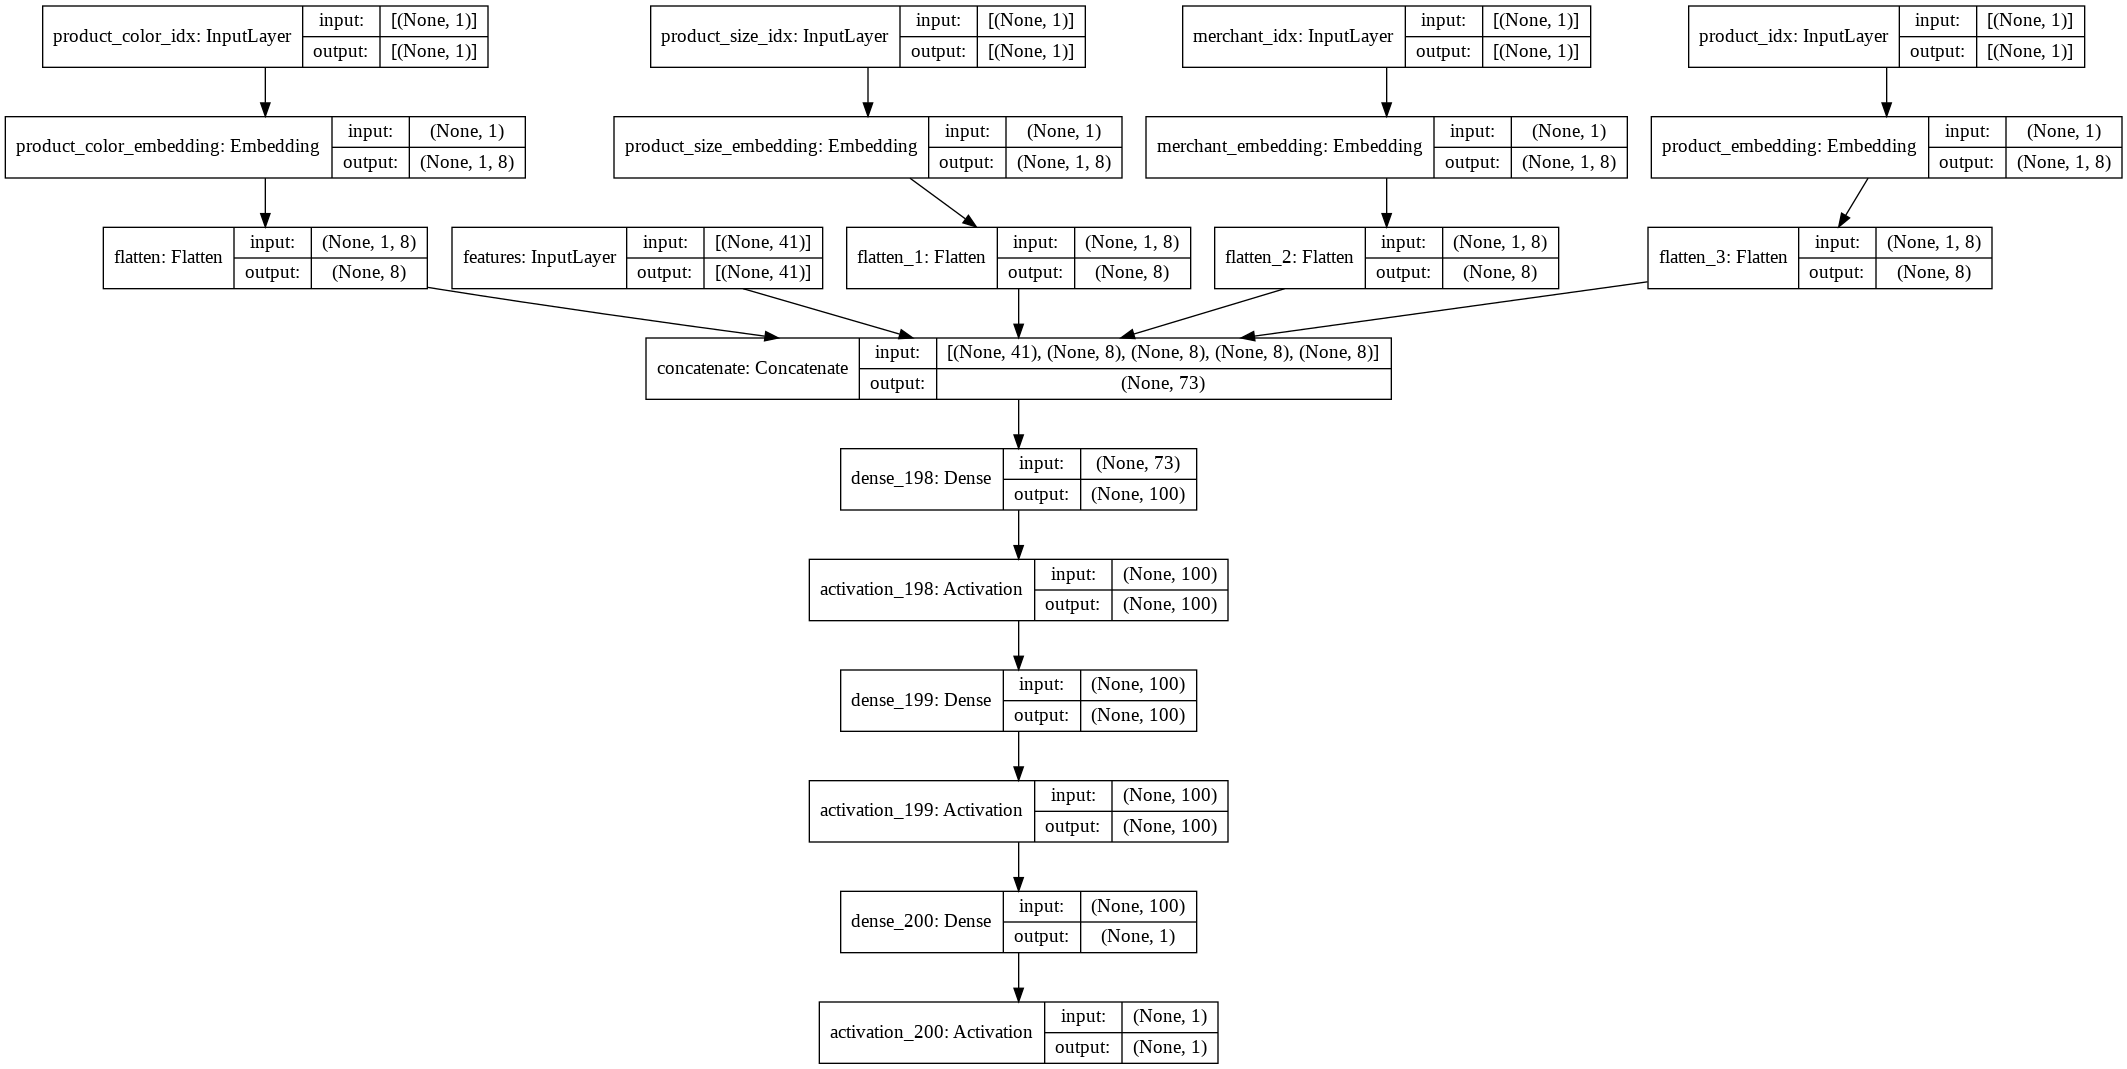

time: 449 ms (started: 2021-01-04 20:28:14 +00:00)


In [ ]:
model_embedding = create_model_embedding()
plot_model(model_embedding, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
nn_model_sk = KerasRegressor(build_fn = create_model_embedding, 
                                 epochs=100, 
                                 batch_size=64, 
                                 verbose=False)
X = np.concatenate([x_train_emb_norm.astype(np.float32), idx_train['product_color'].astype(np.float32).to_numpy().reshape(-1,1),
      idx_train['product_variation_size_id'].astype(np.float32).to_numpy().reshape(-1,1), idx_train['merchant_id'].astype(np.float32).to_numpy().reshape(-1,1),
     idx_train['product_id'].astype(np.float32).to_numpy().reshape(-1,1)], axis=1)

nn_scores = cross_val_score(nn_model_sk, X , y_train_emb_norm.ravel().reshape(-1, 1), cv=5)
print('Scores NN:  {}'.format(nn_scores))
print('Mean Score NN:  {}'.format(nn_scores.mean()))

In [ ]:
model_embedding.fit(
    [x_train_emb_norm.astype(np.float32), idx_train['product_color'].astype(np.float32),
      idx_train['product_variation_size_id'].astype(np.float32), idx_train['merchant_id'].astype(np.float32),
     idx_train['product_id'].astype(np.float32)], 
    y_train_emb_norm.astype(np.float32),
    epochs=100,
    batch_size=16,
    validation_data=([x_test_emb_norm.astype(np.float32), idx_test['product_color'].astype(np.float32),
     idx_test['product_variation_size_id'].astype(np.float32), idx_test['merchant_id'].astype(np.float32),
     idx_test['product_id'].astype(np.float32)], y_test_emb_norm),
    )

Epoch 1/100
81/81 [==============================] - 2s 10ms/step - loss: 0.5999 - mean_absolute_percentage_error: 87.4670 - val_loss: 0.3548 - val_mean_absolute_percentage_error: 74.6140
Epoch 2/100
81/81 [==============================] - 0s 4ms/step - loss: 0.2879 - mean_absolute_percentage_error: 56.2759 - val_loss: 0.3380 - val_mean_absolute_percentage_error: 68.4777
Epoch 3/100
81/81 [==============================] - 0s 4ms/step - loss: 0.2637 - mean_absolute_percentage_error: 65.6968 - val_loss: 0.2939 - val_mean_absolute_percentage_error: 90.1669
Epoch 4/100
81/81 [==============================] - 0s 4ms/step - loss: 0.1757 - mean_absolute_percentage_error: 73.7641 - val_loss: 0.2920 - val_mean_absolute_percentage_error: 72.7408
Epoch 5/100
81/81 [==============================] - 0s 4ms/step - loss: 0.1818 - mean_absolute_percentage_error: 61.0954 - val_loss: 0.2799 - val_mean_absolute_percentage_error: 86.1677
Epoch 6/100
81/81 [==============================] - 0s 5ms/step

time: 38.9 s (started: 2021-01-04 20:28:24 +00:00)


#### Guardar modelos y datos preprocesados

In [ ]:
def save_model(model, name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/Machine Learning II/" + str(name)
  # serialize model to JSON
  model_json = model.to_json()
  with open(model_path + ".json", "w") as json_file:
      json_file.write(model_json)
  # serialize weights to HDF5
  model.save_weights(model_path + ".h5")
  print("Saved model to disk")
  return "Saved"
 
def load_model(name='model'):
  model_path = "/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/Machine Learning II/" + str(name)
  # load json and create model
  json_file = open(model_path + ".json", 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights(model_path + ".h5")
  return loaded_model

In [ ]:
import pickle
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/Machine Learning II/'
data = [x_train, x_train_norm, x_test, x_test_norm, y_train, y_train_norm, y_test, y_test_norm]
with open(PICKLE_PATH+'/preprocessed_data', 'wb') as f:
    pickle.dump(data, f)
with open(PICKLE_PATH+'/linear_regression', 'wb') as f:
    pickle.dump(lr_model, f)
with open(PICKLE_PATH+'/poly_regression', 'wb') as f:
    pickle.dump(clf, f)
with open(PICKLE_PATH+'/random_forest', 'wb') as f:
    pickle.dump(rf_model, f)
with open(PICKLE_PATH+'/svm', 'wb') as f:
    pickle.dump(svm_model, f)

time: 52.2 ms (started: 2021-01-04 20:29:19 +00:00)


In [ ]:
save_model(nn_model, name='model_nn')
save_model(model_embedding, name='model_embedding')

Saved model to disk
Saved model to disk


'Saved'

time: 61.1 ms (started: 2021-01-04 20:33:18 +00:00)


In [ ]:
save_model(lr_model, name='Linear Regression')
save_model(clf, name='Polynomial Regression')
save_model(rf_model, name='Random Forest')
save_model(svm_model, name='Support Vector Machine')
save_model(nn_model_sk, name='Neural Network')
save_model(model_embedding, name='Neural Network with Embeddings')

AttributeError: ignored

## Comparacion

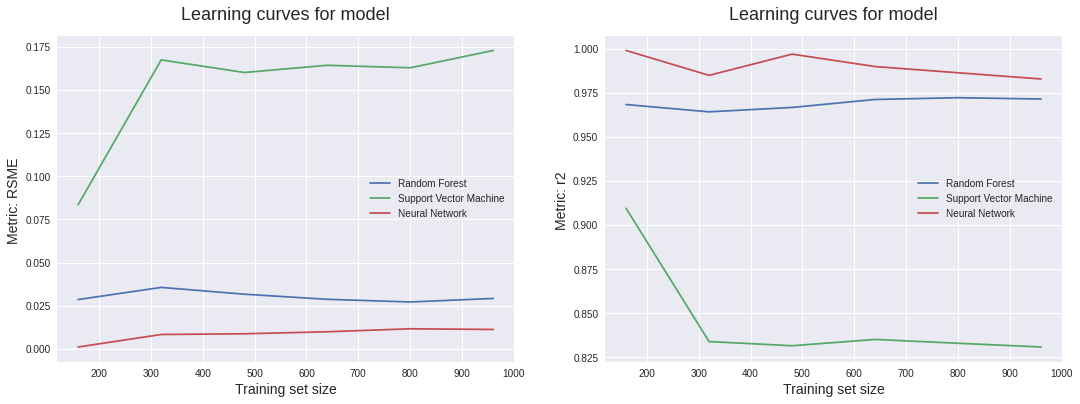

In [ ]:
# Para comparar los modelos, se grafican las evoluciones de las métrica r2 y la función de costo MSE en función
# del tamaño del dataset de entrenamiento. Las curvas obtenidas provienen de realizar un cross-validation de 5 folds 
# y computar el valor medio de las métricas calculadas.
# Se observa como la red neuronal performa mejor que el modelo de Random Forest y bastante mejor que el SVM (podrían ajustarse un poco
# más los parámetros) al obtener un mejor r2 y una menor función de costo. No se incluyo al modelo con embedding ya que no se logro realizar
# la cross validation para una entrada tipo lista (train + embeddings). En caso de lograrse en el transcurso de los días siguientes,
# se verá reflejado el cambio y la posterior comparación. De todas maneras, mediante el entrenamiento realizado más arriba podemos 
# asegurar que mejora el valor de MSE, aunque no sustancialmente.
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.style.use('seaborn')

ax[0].plot(train_sizes, -rf_train_mse.mean(axis=1), label = 'Random Forest')
ax[0].plot(train_sizes, -svm_train_mse.mean(axis=1), label = 'Support Vector Machine')
ax[0].plot(train_sizes, -nn_train_mse.mean(axis=1), label = 'Neural Network')
#plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
ax[0].set_ylabel('Metric: RSME ', fontsize = 14)
ax[0].set_xlabel('Training set size', fontsize = 14)
ax[0].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
ax[0].legend()

plt.style.use('seaborn')
ax[1].plot(train_sizes, rf_train_r2.mean(axis=1), label = 'Random Forest')
ax[1].plot(train_sizes, svm_train_r2.mean(axis=1), label = 'Support Vector Machine')
ax[1].plot(train_sizes, nn_train_r2.mean(axis=1), label = 'Neural Network')
#plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
ax[1].set_ylabel('Metric: r2 ', fontsize = 14)
ax[1].set_xlabel('Training set size', fontsize = 14)
ax[1].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
ax[1].legend()

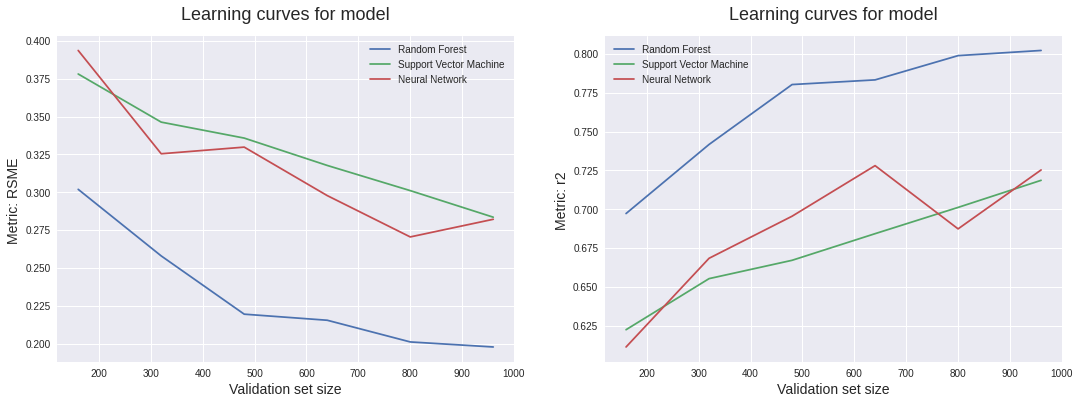

In [ ]:
# Para comparar los modelos, se grafican las evoluciones de las métrica r2 y la función de costo MSE en función
# del tamaño del dataset de validación. Las curvas obtenidas provienen de realizar un cross-validation de 5 folds 
# y computar el valor medio de las métricas calculadas.
# Se observa como el modelo de Random Forest es que mejor genereliza para el set de validación. Podemos suponer 
# entonces que el modelo de redes neuronal esta sufriendo de overfitting (para solucionar esto se podría agregar regularización 
# o simplemente simplificar el modelo).
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
plt.style.use('seaborn')

ax1[0].plot(train_sizes, -rf_valid_mse.mean(axis=1), label = 'Random Forest')
ax1[0].plot(train_sizes, -svm_valid_mse.mean(axis=1), label = 'Support Vector Machine')
ax1[0].plot(train_sizes, -nn_valid_mse.mean(axis=1), label = 'Neural Network')
#plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
ax1[0].set_ylabel('Metric: RSME ', fontsize = 14)
ax1[0].set_xlabel('Validation set size', fontsize = 14)
ax1[0].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
ax1[0].legend()

plt.style.use('seaborn')
ax1[1].plot(train_sizes, rf_valid_r2.mean(axis=1), label = 'Random Forest')
ax1[1].plot(train_sizes, svm_valid_r2.mean(axis=1), label = 'Support Vector Machine')
ax1[1].plot(train_sizes, nn_valid_r2.mean(axis=1), label = 'Neural Network')
#plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
ax1[1].set_ylabel('Metric: r2 ', fontsize = 14)
ax1[1].set_xlabel('Validation set size', fontsize = 14)
ax1[1].set_title('Learning curves for model' , fontsize = 18, y = 1.03)
ax1[1].legend()

# Machine Learning II

## Carga de datos y modelos anteriores

In [ ]:
%%capture
!pip install ipython-autotime
%load_ext autotime

time: 250 µs (started: 2021-01-07 13:18:11 +00:00)


In [ ]:
PICKLE_PATH = '/content/drive/MyDrive/Alfonso/CEIA/Bimestre III/Machine Learning II/'

with open(PICKLE_PATH+'/preprocessed_data', 'rb') as f:
    data = pickle.load(f)
(x_train, x_train_norm, x_test, x_test_norm, y_train, y_train_norm, y_test, y_test_norm) = data

time: 2.55 s (started: 2021-01-07 13:18:11 +00:00)


In [ ]:
with open(PICKLE_PATH+'/linear_regression', 'rb') as f:
    lr_model = pickle.load(f)
with open(PICKLE_PATH+'/poly_regression', 'rb') as f:
    clf = pickle.load(f)
with open(PICKLE_PATH+'/random_forest', 'rb') as f:
    rf_model = pickle.load(f)
with open(PICKLE_PATH+'/svm', 'rb') as f:
    svm_model = pickle.load(f)
#with open(PICKLE_PATH+'/neural_network', 'rb') as f:
#    nn_model_sk = pickle.load(f)

time: 2.67 s (started: 2021-01-07 13:18:13 +00:00)


In [ ]:
model_nn = load_model(name='model_nn')
model_embedding = load_model(name='model_embedding')

time: 8.3 s (started: 2021-01-07 13:18:16 +00:00)


## Hyperparameter Tuning

La optimización o ajuste de hiperparámetros es el problema de elegir un conjunto de hiperparámetros óptimos para un algoritmo de aprendizaje. Un hiperparámetro es un parámetro cuyo valor se utiliza para controlar el proceso de aprendizaje. 

Para los próximos análisis se utilizará el modelo Random Forest Regressor obtenido en el trabajo final de la asignatura Machine Learning I. 

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=5)
rf_model.fit(x_train, y_train)
y_test_pred_mod = rf_model.predict(x_test)

time: 1.03 s (started: 2021-01-07 13:19:35 +00:00)


### Grid Search

Grid Search optimiza el modelo para todas las combinaciones posibles de los valores de los hiperparámtros dados. En este caso en particular se tienen 48 casos (144 considerando que el set de entrenamiento se dividió en 3 folds para permitir la validazación cruzada). 

In [ ]:
from sklearn.model_selection import GridSearchCV

scoring = 'neg_mean_squared_error'
parameters = {'criterion':('mse','mae'), 'n_estimators':[50, 100, 200], 'max_depth':[50, 100], 'min_samples_split':[2, 4], 'min_samples_leaf':[1, 2]}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=5),
                  param_grid=parameters,
                  scoring=scoring,verbose=1, cv=3, refit='r2', return_train_score=True)
rf_grid.fit(x_train, y_train.ravel())

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  7.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=5,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=

time: 7min 35s (started: 2021-01-05 22:22:10 +00:00)


Posterior al entrenamiento nos quedamos con el modelo que tenga el mejor fit respecto a la métrica R2 Score y comparamos su desempeño contra el modelo original sin tuneo. Podemos observar una leve mejora (~2%) en la métrica sobre el set de testeo.
El método es muy costoso computacionalmente y altamente dependiente de los valores elegidos para cada uno de los hiperpárametros, por lo que lo podemos considerar como una opción útil para retoques finos sobre el modelo ya elegido.

In [ ]:
from sklearn.metrics import r2_score
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = rf_grid.best_estimator_.predict(x_train)

# Predecimos sobre nuestro set de test
y_test_pred = rf_grid.best_estimator_.predict(x_test)


# Comaparamos con las etiquetas reales
print('R2 Score Train Set - Grid Search:', round(r2_score(y_train_pred, y_train), 3))
print('R2 Score Test Set - Modelo Original:', round(r2_score(y_test_pred_mod, y_test), 3))
print('R2 Score Test Set - Grid Search:', round(r2_score(y_test_pred, y_test), 3))

R2 Score Train Set - Grid Search: 0.972
R2 Score Test Set - Modelo Original: 0.62
R2 Score Test Set - Grid Search: 0.633
time: 79.7 ms (started: 2021-01-05 22:31:49 +00:00)


### Randomized Search

Randomized Search optimiza el modelo tomando aleatoriamente combinaciones de parámetros dentros los espacios definidos para los mismos. En este caso particular, se limitó la optimización a 5 iteraciones (25 casos considerando 5 folds para la validación cruzada).

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {'criterion':['mse','mae'], 'n_estimators':list(np.linspace(10, 200, 10, dtype=int)), 'max_depth':list(np.linspace(10, 100, 10, dtype=int)), 
              'min_samples_split':list(np.linspace(2, 10, 1, dtype=int)), 'min_samples_leaf':list(np.linspace(1, 6, 1, dtype=int))}
rf_randsr = RandomizedSearchCV(RandomForestRegressor(random_state=5),
                  param_distributions=parameters, n_iter= 5,
                  scoring=scoring,verbose=1, cv=5, refit='r2', return_train_score=True)
rf_randsr.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

time: 1min 55s (started: 2021-01-05 22:32:06 +00:00)


Se elegió al modelo con mejor desempeño respecto a la métrica R2 Score y se lo evaluó sobre el set de testeo. Se observa una mejora en el resultado respecto a Grid Search (64,8% vs 63,3%), con un número aproximadamente 6 veces menor de optimizaciones y un tiempo 4 veces menor. Es un método más rápido y efeciente, pero muy dependiente del rango de valores elegido para los hiperparámentros y sin considerar ninguna otra condición respecto de los mismos.

In [ ]:
from sklearn.metrics import r2_score
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = rf_randsr.best_estimator_.predict(x_train)

# Predecimos sobre nuestro set de test
y_test_pred = rf_randsr.best_estimator_.predict(x_test)

# Comaparamos con las etiquetas reales
print('R2 Score Train Set - Random Search:', round(r2_score(y_train_pred, y_train), 3))
print('R2 Score Test Set - Modelo Original:', round(r2_score(y_test_pred_mod, y_test), 3))
print('R2 Score Test Set - Random Search:', round(r2_score(y_test_pred, y_test), 3))

R2 Score Train Set - Random Search: 0.97
R2 Score Test Set - Modelo Original: 0.62
R2 Score Test Set - Random Search: 0.648
time: 50 ms (started: 2021-01-05 22:34:05 +00:00)


### Automated Hyperparameter tuning

Los resultados recientes sugieren que la optimización hiperparamétrica bayesiana de los modelos de aprendizaje es más eficiente que los demás métodos, generando un mejor rendimiento general en el conjunto de pruebas y menor tiempo para la optimización. 

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

time: 674 ms (started: 2021-01-07 13:21:21 +00:00)


In [ ]:
space = {'criterion': hp.choice('criterion', ['mse', 'mae'] ),
         'max_depth': hp.quniform('max_depth', 10, 100, 10),
         'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
         'min_samples_split': hp.uniform('min_samples_split', 0, 1)}

time: 3.66 ms (started: 2021-01-07 13:21:22 +00:00)


In [ ]:
from sklearn.model_selection import cross_val_score
def objective(space):
  model = RandomForestRegressor(criterion= space['criterion'],
                                max_depth = space['max_depth'],
                                min_samples_leaf = space['min_samples_leaf'],
                                min_samples_split = space['min_samples_split'])
  nmse = cross_val_score(model, x_train, y_train, scoring='neg_mean_squared_error', cv=5).mean()
  return {'loss': nmse, 'status': STATUS_OK}
  

time: 2.81 ms (started: 2021-01-07 13:21:24 +00:00)


In [ ]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals= 50,
            trials=trials)

100%|██████████| 50/50 [01:29<00:00,  1.79s/it, best loss: -3325375830.3315997]
time: 1min 29s (started: 2021-01-07 13:28:15 +00:00)


In [ ]:
best

{'criterion': 1,
 'max_depth': 90.0,
 'min_samples_leaf': 0.29014348346456165,
 'min_samples_split': 0.8749836691871121}

time: 6.46 ms (started: 2021-01-07 13:29:46 +00:00)


In [ ]:
rf_automated = RandomForestRegressor(criterion='mae',
                                     max_depth = best['max_depth'],
                                     min_samples_leaf = best['min_samples_leaf'],
                                     min_samples_split = best['min_samples_split']
                                     ).fit(x_train, y_train)

time: 200 ms (started: 2021-01-07 13:31:49 +00:00)


In [ ]:
from sklearn.metrics import r2_score
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = rf_automated.predict(x_train)

# Predecimos sobre nuestro set de test
y_test_pred = rf_automated.predict(x_test)

# Comaparamos con las etiquetas reales
print('R2 Score Train Set - Automated:', round(r2_score(y_train_pred, y_train), 3))
print('R2 Score Test Set - Modelo Original:', round(r2_score(y_test_pred_mod, y_test), 3))
print('R2 Score Test Set - Automated:', round(r2_score(y_test_pred, y_test), 3))

R2 Score Train Set - Automated: 0.0
R2 Score Test Set - Modelo Original: 0.62
R2 Score Test Set - Automated: 0.0
time: 46.4 ms (started: 2021-01-07 13:31:51 +00:00)


## Reducción de dimensionalidad

Los métodos de reducción de dimensionalidad apuntan a reducir la cantidad de variables de un dataset, con el objetivo de poder visualizar la información o para limitarnos al uso de la variables que expliquen el mayor porcentaje de la varianza de los datos.

En este caso particular compararemos distintos métodos, mostrando su visualización y su desempeño respecto al dataset en cuestión.

In [ ]:
import plotly.graph_objects as go
def plot_2d(component1, component2):
    
    fig = go.Figure(data=go.Scatter(
        x = component1,
        y = component2,
        mode='markers',
        marker=dict(
            size=20,
            color=component2, #set color equal to a variable
            colorscale='Rainbow', # one of plotly colorscales
            showscale=True,
            line_width=1
        )
    ))
    fig.update_layout(margin=dict( l=100,r=100,b=100,t=100),width=2000,height=1200)                 
    fig.layout.template = 'plotly_dark'
    
    fig.show()

def plot_3d(component1,component2,component3):
    fig = go.Figure(data=[go.Scatter3d(
        x=component1,
        y=component2,
        z=component3,
        mode='markers',
        marker=dict(
            size=10,
            color=component2,                # set color to an array/list of desired values
            colorscale='Rainbow',   # choose a colorscale
            opacity=1,
            line_width=1
        )
    )])
# tight layout
    fig.update_layout(margin=dict(l=50,r=50,b=50,t=50),width=1800,height=1000)
    fig.layout.template = 'plotly_dark'
    
    fig.show()

time: 16.9 ms (started: 2021-01-05 21:42:09 +00:00)


#### PCA

Aplicamos PCA (Principal Component Analysis) para reducir el dataset a 3 dimensiones.

In [ ]:
from sklearn.decomposition import PCA
x_pca = PCA(3)

x_train_pca = x_pca.fit_transform(x_train)
x_test_pca = x_pca.transform(x_test)

In [ ]:
rf_pca = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=5)
rf_pca.fit(x_train_pca, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

time: 441 ms (started: 2021-01-05 21:41:04 +00:00)


Entrenamos el modelo original con los datos reducidos y observamos una pequeña reducción en el desempeño de la métrica. Esto quiere decir que el modelo logra explicar un gran porcentaje de la varianza de los datos con sólo 3 componentes.

In [ ]:
from sklearn.metrics import r2_score
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = rf_pca.predict(x_train_pca)

# Predecimos sobre nuestro set de test
y_test_pred = rf_pca.predict(x_test_pca)

# Comaparamos con las etiquetas reales
print('R2 Score Train Set - PCA:', round(r2_score(y_train_pred, y_train), 3))
print('R2 Score Test Set - Modelo Original:', round(r2_score(y_test_pred_mod, y_test), 3))
print('R2 Score Test Set - PCA:', round(r2_score(y_test_pred, y_test), 3))

R2 Score Train Set - PCA: 0.96
R2 Score Test Set - Modelo Original: 0.62
R2 Score Test Set - PCA: 0.609
time: 49.6 ms (started: 2021-01-05 21:41:07 +00:00)


In [ ]:
plot_3d(x_test_pca[:,0], x_test_pca[:,1], x_test_pca[:,2])

time: 1.27 s (started: 2021-01-05 21:42:15 +00:00)


### t - SNE

t - SNE se utliza muchas veces posterior a PCA, una vez que ya se ha reducido el tamaño del dataset, para lograr una visualización 2D o 3D.

In [ ]:
from sklearn.manifold import TSNE
x_tsne = TSNE(3)

x_train_tsne = x_tsne.fit_transform(x_train)
x_test_tsne = x_tsne.fit_transform(x_test)

time: 21.4 s (started: 2021-01-05 21:30:34 +00:00)


In [ ]:
plot_3d(x_test_tsne[:,0], x_test_tsne[:,1], x_test_tsne[:,2])

time: 214 ms (started: 2021-01-05 21:43:38 +00:00)


### UMAP

UMAP es un método de reducción de la dimensionalidad no lineal, es muy eficaz para visualizar cúmulos o grupos de puntos de datos y sus proximidades relativas. 
En este caso entrenamos al modelo con los datos reducidos por UMAP para comparar el desempeño contra PCA.

In [ ]:
import umap
reducer = umap.UMAP(random_state=42, n_components=3)
x_train_umap = reducer.fit_transform(x_train)
x_test_umap = reducer.transform(x_test)

time: 10.1 s (started: 2021-01-05 21:46:28 +00:00)


In [ ]:
rf_umap = RandomForestRegressor(n_estimators=100, max_depth=100, random_state=5)
rf_umap.fit(x_train_umap, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=100, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=5, verbose=0, warm_start=False)

time: 347 ms (started: 2021-01-05 21:48:04 +00:00)


Tal como observamos más abajo, UMAP no fue capaz de representar la varianza del modelo en 3 dimensiones tal como lo hizo PCA. 

In [ ]:
from sklearn.metrics import r2_score
# Predecimos sobre nuestro set de entrenamieto
y_train_pred = rf_umap.predict(x_train_umap)

# Predecimos sobre nuestro set de test
y_test_pred = rf_umap.predict(x_test_umap)

# Comaparamos con las etiquetas reales
print('R2 Score Train Set - UMAP:', round(r2_score(y_train_pred, y_train), 3))
print('R2 Score Test Set - Modelo Original:', round(r2_score(y_test_pred_mod, y_test), 3))
print('R2 Score Test Set - UMAP:', round(r2_score(y_test_pred, y_test), 3))

R2 Score Train Set - UMAP: 0.919
R2 Score Test Set - Modelo Original: 0.62
R2 Score Test Set - UMAP: 0.389
time: 48.2 ms (started: 2021-01-05 21:48:34 +00:00)


In [ ]:
plot_3d(x_test_umap[:,0], x_test_umap[:,1], x_test_umap[:,2])

time: 215 ms (started: 2021-01-05 21:48:50 +00:00)


## Conclusiones

Tanto hyperparameter tuning como reducción de dimensionalidad son dos herramientas interesantes y muy útiles a la hora de mejorar tanto el desempeño del modelo tanto respecto a efectividad como a necesidad de cómputo. 

Para hyperparameter tuning, podemos afirmar que lo ideal sería utilizar un método automatizado, aunque si fuera el caso de un retoque fino en donde se tiene cierta información de los rangos de valores, podría ser usado también Random Search. Grid Search es un método muy básico pero que podría ser útil como primera aproximación con pocas iteraciones para entender en que rangos se obtienen mejores desempeños.

Para reducción de dimensionalidad, es difícil indicar al momento en que caso particular es mejor un método o el otro. Será necesario probar varios de ellos y entender porque uno o otro dan mejor resultado para determinado set de datos. Una práctica interesante es obtener las variables que explican el 95% de la varianza de los datos, agregar estás variables al dataset original y utilizar todos los datos para entrenar el modelo. Pueden llegar a obtenerse mejores resultados pero a costa de un riesgo de aumentar el overfitting al momento de generalizar sobre nueva información.